# Modelo para App

Librerías y extracción de datos

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

import pickle

import shap
import xgboost as xgb
import seaborn as sns
import joblib


In [2]:
# DF
data = pd.read_csv('dataframe_con_info_adicional.csv')

# 'hora_llegada' in datetime format
data['hora_llegada'] = pd.to_datetime(data['hora_llegada'])

# adding 'hora_llegada' to 'dia_semana'
data['dia_semana'] = data['hora_llegada'].dt.dayofweek

# features and target
features = ['nivel_trafico', 'clima', 'accidente', 'es_hora_punta', 'dia_del_ano', 'distancia', 'es_festivo', 'dia_semana']
target = 'retraso'

X = data[features]
y = data[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#  Data scalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled=X_train
#X_test_scaled=X_test

In [3]:
data.tail()

,bus_id,nivel_trafico,clima,accidente,hora_llegada,es_hora_punta,dia_del_ano,distancia,es_festivo,dia_de_la_semana,retraso,dia_semana
157249,2,0,0,0,2023-12-31,False,365,311.496610,False,6,1,6
157250,3,0,1,0,2023-12-31,False,365,391.855599,False,6,3,6
157251,4,0,0,0,2023-12-31,False,365,103.352199,False,6,1,6
157252,5,0,0,0,2023-12-31,False,365,238.102511,False,6,1,6
157253,6,0,0,0,2023-12-31,False,365,403.207173,False,6,1,6


El dataframe está compuesto por:
* Bus_id: id del bus
* Nivel del tráfico: 0 ninguno, 1 poco, 2 mucho
* Clima: 0 despejado, 1 malo, 2 terrible
* Hora con día de llegada (no sirve para nada, es mas para ordenar los valores generados)
* es_hora_punta: si es hora punta o no, si lo es aumenta el retraso
* dia_del_ano: como la hora de llegada, para ordenar los datos cuando se generan
* es_festivo: si lo es reduce el tráfico
* dia_de_la_semana: ortientativo, no sirve para nada
* retraso: retraso en minutos producido
* dia_semana: si es sabado o domingo no aumenta el tráfico, si es un lunes o viernes lo hace


## Modelo LSTM

In [13]:
# Convertir los datos a secuencias para el modelo LSTM
def to_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Ajusta según la longitud de la secuencia deseada
X_train_seq, y_train_seq = to_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = to_sequences(X_test_scaled, y_test, time_steps)

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

with tf.device('/device:GPU:0'):
    # Entrenar el modelo
    try:
        model.load_weights('model_weights_LSTM.h5')
        with open('history_LSTM.pkl', 'rb') as file:
            history = pickle.load(file)
    except (OSError, FileNotFoundError):
        # Si no se encuentran los archivos, entrena el modelo y guarda los pesos e historial
        history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=1000, validation_split=0.1, verbose=1)
        model.save_weights('model_weights.h5')
        with open('history_LSTM.pkl', 'wb') as file:
            pickle.dump(history.history if hasattr(history, 'history') else history, file)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_seq)

# Calcular el error absoluto medio en las predicciones
mae = mean_absolute_error(y_test_seq, y_pred)
print(f'MAE en el conjunto de prueba: {mae}')

Epoch 1/20
114/114 [==============================] - 21s 149ms/step - loss: 25.3216 - val_loss: 21.4683
Epoch 2/20
114/114 [==============================] - 16s 144ms/step - loss: 22.3002 - val_loss: 20.9928
Epoch 3/20
114/114 [==============================] - 17s 144ms/step - loss: 22.2957 - val_loss: 20.7061
Epoch 4/20
114/114 [==============================] - 18s 155ms/step - loss: 21.5634 - val_loss: 20.5388
Epoch 5/20
114/114 [==============================] - 17s 152ms/step - loss: 21.4666 - val_loss: 20.5514
Epoch 6/20
114/114 [==============================] - 18s 159ms/step - loss: 21.3453 - val_loss: 20.4860
Epoch 7/20
114/114 [==============================] - 18s 158ms/step - loss: 21.2985 - val_loss: 20.4835
Epoch 8/20
114/114 [==============================] - 19s 164ms/step - loss: 21.2681 - val_loss: 20.4613
Epoch 9/20
114/114 [==============================] - 18s 161ms/step - loss: 21.2535 - val_loss: 20.5286
Epoch 10/20
114/114 [==============================] - 

In [6]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/lstm/transpose' defined at (most recent call last):
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\IU\AppData\Local\Temp\ipykernel_8236\3615335812.py", line 2, in <module>
      loss, accuracy = model.evaluate(X_test_scaled, y_test)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\rnn\lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend.py", line 4783, in rnn
      inputs = tf.nest.map_structure(swap_batch_timestep, inputs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend.py", line 4780, in swap_batch_timestep
      return tf.compat.v1.transpose(input_t, axes)
Node: 'sequential/lstm/transpose'
Detected at node 'sequential/lstm/transpose' defined at (most recent call last):
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\IU\AppData\Local\Temp\ipykernel_8236\3615335812.py", line 2, in <module>
      loss, accuracy = model.evaluate(X_test_scaled, y_test)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\rnn\lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend.py", line 4783, in rnn
      inputs = tf.nest.map_structure(swap_batch_timestep, inputs)
    File "c:\Users\IU\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend.py", line 4780, in swap_batch_timestep
      return tf.compat.v1.transpose(input_t, axes)
Node: 'sequential/lstm/transpose'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node sequential/lstm/transpose}}]]
	 [[mean_squared_error/cond/then/_48/mean_squared_error/cond/cond/then/_111/mean_squared_error/cond/cond/remove_squeezable_dimensions/cond_1/pivot_f/_176/_63]]
  (1) INVALID_ARGUMENT:  transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node sequential/lstm/transpose}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_18432]

## Modelo secuelcial de 6 capas con regularización

In [7]:
# Convertir a tensores de TensorFlow
X_train_tensor = tf.constant(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values, dtype=tf.float32)
X_test_tensor = tf.constant(X_test_scaled, dtype=tf.float32)

# Crear y entrenar un modelo de regresión lineal con TensorFlow GPU
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Agregar Dropout para regularización
    Dense(64, activation='relu'),
    Dropout(0.5),  # Agregar Dropout para regularización
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida para regresión
])
model.compile(optimizer='adam', loss='mse')


with tf.device('/device:GPU:0'):
    # Entrenar el modelo
    try:
        model.load_weights('model_weights_6_layers.h5')
        with open('history_R.pkl', 'rb') as file:
            history = pickle.load(file)
    except (OSError, FileNotFoundError):
        # Si no se encuentran los archivos, entrena el modelo y guarda los pesos e historial
        history = model.fit(X_train_tensor, y_train_tensor, epochs=15, batch_size=1000, validation_split=0.1, verbose=1)
        model.save_weights('model_weights_R.h5')
        with open('history_R.pkl', 'wb') as file:
            pickle.dump(history.history if hasattr(history, 'history') else history, file)



# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_tensor).flatten()

# Calcular el error absoluto medio en las predicciones
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE en el conjunto de prueba: {mae}')

Epoch 1/15
114/114 [==============================] - 2s 9ms/step - loss: 15.0843 - val_loss: 3.3619
Epoch 2/15
114/114 [==============================] - 1s 6ms/step - loss: 5.8124 - val_loss: 3.2886
Epoch 3/15
114/114 [==============================] - 1s 5ms/step - loss: 5.1629 - val_loss: 3.2652
Epoch 4/15
114/114 [==============================] - 1s 5ms/step - loss: 4.7478 - val_loss: 3.2210
Epoch 5/15
114/114 [==============================] - 1s 5ms/step - loss: 4.4588 - val_loss: 3.3320
Epoch 6/15
114/114 [==============================] - 1s 6ms/step - loss: 4.2864 - val_loss: 3.2583
Epoch 7/15
114/114 [==============================] - 1s 6ms/step - loss: 4.1173 - val_loss: 3.4936
Epoch 8/15
114/114 [==============================] - 1s 7ms/step - loss: 3.9810 - val_loss: 3.4246
Epoch 9/15
114/114 [==============================] - 1s 8ms/step - loss: 3.7961 - val_loss: 3.7514
Epoch 10/15
114/114 [==============================] - 1s 6ms/step - loss: 3.7074 - val_loss: 3.613

In [8]:
# Assuming y_test is the true target values in your regression problem

# Calculate the percentage error
percentage_error = (mae / np.mean(np.abs(y_test))) * 100

print(f'Percentage Error on the test set: {percentage_error:.2f}%')

Percentage Error on the test set: 30.02%


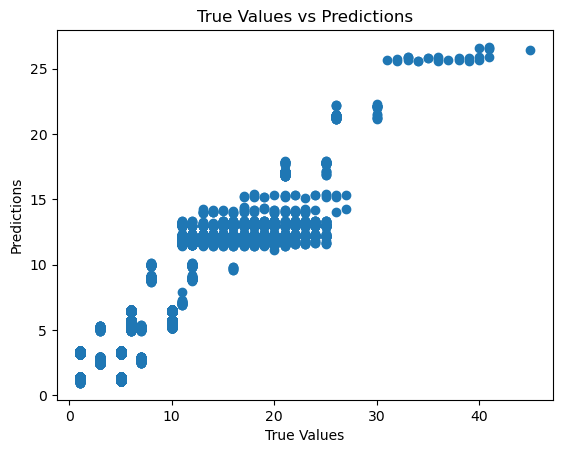

In [9]:
import matplotlib.pyplot as plt

# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [10]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f'R-squared on the test set: {r_squared:.4f}')


R-squared on the test set: 0.7976


## XGBOOST

In [14]:
# Initial parameters
xgb_params = {
    'tree_method': 'gpu_hist',          # Use of a GPU to accelerate the process
    'gpu_id': 0,                        # GPU ID
    'objective': 'reg:squarederror',    # Indicates a Regression problem
    'min_child_weight': 0.1,            # Minimum weight required in a leaf node of the tree
    'learning_rate': 0.05,              # Moderate learning rate
    'n_estimators': 10000,              # Initial number of trees
    'max_depth': 100,                   # Maximum depth of the trees
    'subsample': 0.9,                   # Use 90% of the samples to fit each tree
    'colsample_bytree': 0.1,            # Use 10% of the columns to fit each tree
    'gamma': 0.1,                       # Moderated regularization
    'random_state': 42,                 # Random seed for reproducibility
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}

xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train_scaled, y_train)

# Save model
model_filename = 'xgboost_model.joblib'
joblib.dump(xgb_model, model_filename)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


['xgboost_model.joblib']

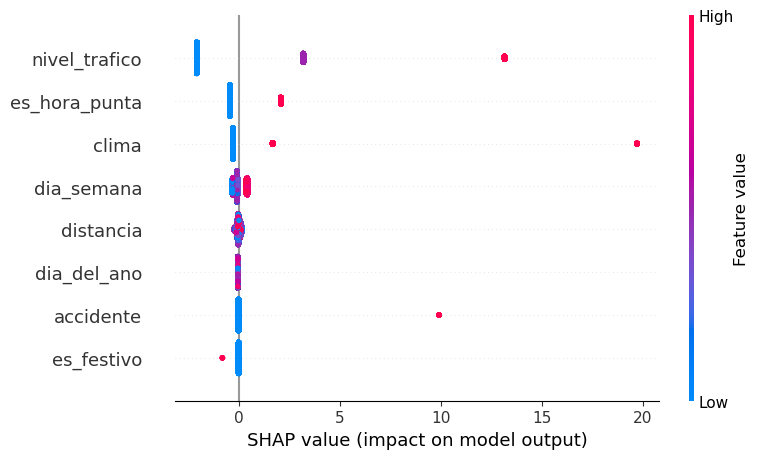

In [15]:
# Using SHAP values for Explainability
explainer = shap.Explainer(xgb_model)

# Getting SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Waterfall graph
sample_ind = 0
shap.summary_plot(shap_values, X_test_scaled, feature_names=features, show=False)
plt.show()

In [36]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Define the input parameters for prediction
#features = ['nivel_trafico', 'clima', 'accidente', 'es_hora_punta', 'dia_del_ano', 'distancia', 'es_festivo', 'dia_semana']
sample_input_params = np.array([[1, 0, 0,False,100,200,False,3]])

# Scale the input parameters if needed (use the same scaler you used for training)
scaled_sample_input_params = scaler.transform(sample_input_params)

# Make a prediction
prediction = loaded_model.predict(sample_input_params)

# Print the prediction
print(f'Prediction for the input parameters: {prediction[0]}')

Prediction for the input parameters: 1.7369762659072876


X does not have valid feature names, but StandardScaler was fitted with feature names


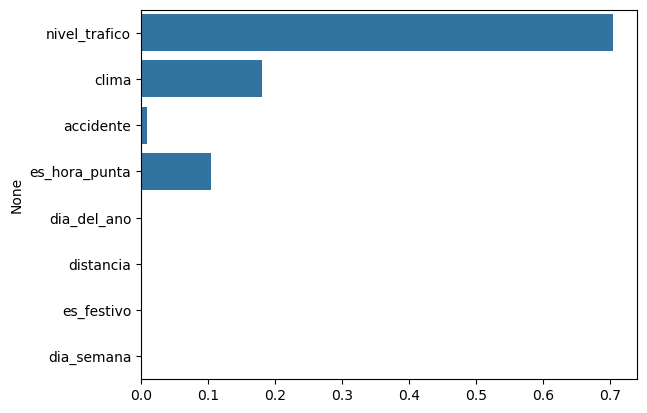

In [37]:
# Get feature importances
feature_importances = loaded_model.feature_importances_

# Visualize feature importances
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=feature_importances, y=X.columns)
plt.show()

### Learning curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Suponiendo que tienes X_train_scaled e y_train ya definidos

# Función para graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Graficar la curva de aprendizaje
title = "Learning Curves (XGBoost)"
cv = 5  # Número de folds para validación cruzada
plot_learning_curve(xgb_model, title, X_train_scaled[::30000], y_train[::30000], ylim=(0, 1.01), cv=cv, n_jobs=-1)

plt.show()


### Metrics

In [35]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score, confusion_matrix,classification_report
y_pred = xgb_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 0.9966389338812308
Mean Squared Error: 2.473548011705149
R-squared: 0.9005591535985401
Accuracy: 0.5768020094750564


    Un MAE de aproximadamente 0.9966 indica un buen rendimiento, especialmente si los retrasos son típicamente bajos (1 a 10 minutos).
    
    Un MSE de 2.4735 muestra una varianza más alta en los errores, pero teniendo en cuenta que los datos se han generado de forma aleatoria, teniendo casos donde despunta el retraso, se puede decir que el resultado es es esperado

    Un R^2 de 0.9006 sugiere un buen ajuste del modelo a los datos, explicando una gran parte de la variabilidad en los retrasos.

In [ ]:
# Visualizar cómo se comporta cada característica en el proceso de decisión
for feature in features:
    plt.figure(figsize=(8, 4))
    plt.scatter(X_test[feature], y_test, label='Real', alpha=0.5)
    plt.scatter(X_test[feature], y_pred, label='Predicción', alpha=0.5)
    plt.title(f'{feature} vs. Retraso')
    plt.xlabel(feature)
    plt.ylabel('Retraso')
    plt.legend()
    plt.show()